# 1. Load data

In [1]:
import json, pandas as pd
import networkx as nx

# Read interactions from preprocessed json file in data_preprocessing.ipynb
with open('../datasets/interactions_poetry.json') as f:
	users = pd.DataFrame(json.loads(line) for line in f)

# is it necessary? it doesn't seem to be used
with open('../datasets/books_poetry.json') as f:
	items = pd.DataFrame(json.loads(line) for line in f)

# Make an empty graph
G = nx.Graph()

# Add user nodes to the Graph (377799 users)
G.add_nodes_from(users['user_id'], type = 'user')
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges()) # Num nodes: 377799 . Num edges: 0

# Add item nodes to the graph (36514 books)
G.add_nodes_from(users['book_id'], type = 'book')

# Make a bipartite graph
edges = [(row['user_id'], row['book_id']) for index, row in users.iterrows()]
G.add_edges_from(edges)

print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges()) # Num nodes: 414313 . Num edges: 2734350

Num nodes: 377799 . Num edges: 0
Num nodes: 414313 . Num edges: 2734350


In [2]:
# Find kcore of given graph; it might take some time(7 mins in my case)
# kcore : a maximal subgraph that contains nodes of degree k or more
kcore = 30
G = nx.k_core(G, kcore)
print('Num nodes:', G.number_of_nodes(), '. Num edges:', G.number_of_edges()) # Num nodes: 17738 . Num edges: 767616

Num nodes: 17738 . Num edges: 767616


In [11]:
# print kcore graph
list(G.nodes(data=True))[:5]

[(np.int64(1443), {'type': 'book'}),
 (np.int64(12274), {'type': 'book'}),
 (np.int64(4656), {'type': 'book'}),
 (np.int64(6157), {'type': 'user'}),
 (np.int64(16943), {'type': 'user'})]

# 2. Graph Dataset

In [18]:
# Since torch-scatter, torch-sparse, and umap-learn will not be used, I only installed torch-geometric
!pip install torch-geometric

# !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import numpy as np

n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()

sorted_nodes = sorted(list(G.nodes()))

# change book_ids and user_ids into integers
node2id = dict(zip(sorted_nodes, np.arange(n_nodes)))
id2node = dict(zip(np.arange(n_nodes), sorted_nodes))

G = nx.relabel_nodes(G, node2id)

In [10]:
list(G.nodes(data=True))[:5]

[(np.int64(1443), {'type': 'book'}),
 (np.int64(12274), {'type': 'book'}),
 (np.int64(4656), {'type': 'book'}),
 (np.int64(6157), {'type': 'user'}),
 (np.int64(16943), {'type': 'user'})]

In [26]:
# get user and item indices from the graph
user_idx = [i for i, v in enumerate(node2id.keys()) if 'user' in G.nodes[i]['type']]
item_idx = [i for i, v in enumerate(node2id.keys()) if 'book' in G.nodes[i]['type']]
n_user = len(user_idx)
n_item = len(item_idx)

print(n_user, n_item) # 11842 5896

11842 5896


In [17]:
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit

num_nodes = G.number_of_nodes() # 17738 = 11842 + 5896
edge_idx = torch.Tensor(np.array(G.edges()).T) # torch.Size([2, 767616]) = [2, n_edges]
graph_data = Data(edge_index = edge_idx, num_nodes = num_nodes)

# convert to train/val/test splits
transform = RandomLinkSplit(
    is_undirected=True, 
    add_negative_train_samples=False, 
    neg_sampling_ratio=0,
    num_val=0.15, num_test=0.15
)
train_split, val_split, test_split = transform(graph_data)

In [43]:
print(train_split)
print(train_split.edge_index.shape)
print(train_split.edge_index[:,:5])
print(train_split.edge_label_index.shape)
print(train_split.edge_label_index[:,:5])

print(val_split)
print(val_split.edge_index.shape)
print(val_split.edge_index[:,:5])
print(val_split.edge_label_index.shape)
print(val_split.edge_label_index[:,:5])

print(test_split)
print(test_split.edge_index.shape)
print(test_split.edge_index[:,:5])  
print(test_split.edge_label_index.shape)
print(test_split.edge_label_index[:,:5])

Data(edge_index=[2, 546860], num_nodes=17738, edge_label=[273430], edge_label_index=[2, 273430])
torch.Size([2, 546860])
tensor([[  900.,   348.,  9856.,  1030.,  6213.],
        [10642.,   819., 10118., 14292.,  6573.]])
torch.Size([2, 273430])
tensor([[  900.,   348.,  9856.,  1030.,  6213.],
        [10642.,   819., 10118., 14292.,  6573.]])
Data(edge_index=[2, 546860], num_nodes=17738, edge_label=[58592], edge_label_index=[2, 58592])
torch.Size([2, 546860])
tensor([[  900.,   348.,  9856.,  1030.,  6213.],
        [10642.,   819., 10118., 14292.,  6573.]])
torch.Size([2, 58592])
tensor([[  812.,  6148.,  5553., 10629.,   959.],
        [11750., 16760., 17266., 13789., 16063.]])
Data(edge_index=[2, 664044], num_nodes=17738, edge_label=[58592], edge_label_index=[2, 58592])
torch.Size([2, 664044])
tensor([[  900.,   348.,  9856.,  1030.,  6213.],
        [10642.,   819., 10118., 14292.,  6573.]])
torch.Size([2, 58592])
tensor([[   28.,  9508.,  3324.,  1361.,  9725.],
        [ 4179.,

In [9]:
# Edge index: message passing edges
train_split.edge_index = train_split.edge_index.type(torch.int64)
val_split.edge_index = val_split.edge_index.type(torch.int64)
test_split.edge_index = test_split.edge_index.type(torch.int64)
# Edge label index: supervision edges
train_split.edge_label_index = train_split.edge_label_index.type(torch.int64)
val_split.edge_label_index = val_split.edge_label_index.type(torch.int64)
test_split.edge_label_index = test_split.edge_label_index.type(torch.int64)

print(f"Train set has {train_split.edge_label_index.shape[1]} positives supervision edges")
print(f"Validation set has {val_split.edge_label_index.shape[1]} positive supervision edges")
print(f"Test set has {test_split.edge_label_index.shape[1]} positive supervision edges")

print(f"Train set has {train_split.edge_index.shape[1]} message passing edges")
print(f"Validation set has {val_split.edge_index.shape[1]} message passing edges")
print(f"Test set has {test_split.edge_index.shape[1]} message passing edges")

Train set has 273957 positives upervision edges
Validation set has 58705 positive supervision edges
Test set has 58705 positive supervision edges
Train set has 547914 message passing edges
Validation set has 547914 message passing edges
Test set has 665324 message passing edges


In [10]:
from typing import Optional, Union

from torch import Tensor
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.nn import Embedding, ModuleList, Linear
import torch.nn.functional as F

from torch_geometric.nn.conv import LGConv, GATConv, SAGEConv
from torch_geometric.typing import Adj, OptTensor, SparseTensor



class BPRLoss(_Loss):
    __constants__ = ['lambda_reg']
    lambda_reg: float

    def __init__(self, lambda_reg: float = 0, **kwargs):
        super().__init__(None, None, "sum", **kwargs)
        self.lambda_reg = lambda_reg

    def forward(self, positives: Tensor, negatives: Tensor,
                parameters: Tensor = None) -> Tensor:
        n_pairs = positives.size(0)
        log_prob = F.logsigmoid(positives - negatives).sum()
        regularization = 0

        if self.lambda_reg != 0:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2) 

        return (-log_prob + regularization) / n_pairs

class GCN(torch.nn.Module):

    def __init__(
        self,
        num_nodes: int,
        embedding_dim: int,
        num_layers: int,
        alpha: Optional[Union[float, Tensor]] = None,
        alpha_learnable = False,
        conv_layer = "LGC",
        name = None,
        **kwargs,
    ):
        super().__init__()
        alpha_string = "alpha" if alpha_learnable else ""
        self.name = f"LGCN_{conv_layer}_{num_layers}_e{embedding_dim}_nodes{num_nodes}_{alpha_string}"
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        if alpha_learnable == True:
          alpha_vals = torch.rand(num_layers+1)
          alpha = nn.Parameter(alpha_vals/torch.sum(alpha_vals))
          print(f"Alpha learnable, initialized to: {alpha.softmax(dim=-1)}")
        else:
          if alpha is None:
              alpha = 1. / (num_layers + 1)

          if isinstance(alpha, Tensor):
              assert alpha.size(0) == num_layers + 1
          else:
              alpha = torch.tensor([alpha] * (num_layers + 1))

        self.register_buffer('alpha', alpha)

        self.embedding = Embedding(num_nodes, embedding_dim)

        # initialize convolutional layers 
        self.conv_layer = conv_layer
        if conv_layer == "LGC":  
          self.convs = ModuleList([LGConv(**kwargs) for _ in range(num_layers)])
        elif conv_layer == "GAT":
          # initialize Graph Attention layer with multiple heads
          # initialize linear layers to aggregate heads 
          n_heads = 5
          self.convs = ModuleList(
              [GATConv(in_channels = embedding_dim, out_channels = embedding_dim, heads = n_heads, dropout = 0.5, **kwargs) for _ in range(num_layers)]
          )
          self.linears = ModuleList([Linear(n_heads * embedding_dim, embedding_dim) for _ in range(num_layers)])

        elif conv_layer == "SAGE":
          #  initialize GraphSAGE conv
          self.convs = ModuleList(
              [SAGEConv(in_channels = embedding_dim, out_channels = embedding_dim, **kwargs) for _ in range(num_layers)]
          )

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.embedding.weight)
        for conv in self.convs:
            conv.reset_parameters()

    def get_embedding(self, edge_index: Adj) -> Tensor:
        x = self.embedding.weight
        
        weights = self.alpha.softmax(dim=-1)
        out = x * weights[0]

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            if self.conv_layer == "GAT":
              x = self.linears[i](x)
            out = out + x * weights[i + 1]

        return out

    def initialize_embeddings(self, data):
      # initialize with the data node features
        self.embedding.weight.data.copy_(data.node_feature)


    def forward(self, edge_index: Adj,
                edge_label_index: OptTensor = None) -> Tensor:
        if edge_label_index is None:
            if isinstance(edge_index, SparseTensor):
                edge_label_index = torch.stack(edge_index.coo()[:2], dim=0)
            else:
                edge_label_index = edge_index

        out = self.get_embedding(edge_index)

        return self.predict_link_embedding(out, edge_label_index)

    def predict_link(self, edge_index: Adj, edge_label_index: OptTensor = None,
                     prob: bool = False) -> Tensor:
       
        pred = self(edge_index, edge_label_index).sigmoid()
        return pred if prob else pred.round()
    
    def predict_link_embedding(self, embed: Adj, edge_label_index: Adj) -> Tensor: 

        embed_src = embed[edge_label_index[0]]
        embed_dst = embed[edge_label_index[1]]
        return (embed_src * embed_dst).sum(dim=-1)


    def recommend(self, edge_index: Adj, src_index: OptTensor = None,
                  dst_index: OptTensor = None, k: int = 1) -> Tensor:
        out_src = out_dst = self.get_embedding(edge_index)

        if src_index is not None:
            out_src = out_src[src_index]

        if dst_index is not None:
            out_dst = out_dst[dst_index]

        pred = out_src @ out_dst.t()
        top_index = pred.topk(k, dim=-1).indices

        if dst_index is not None:  # Map local top-indices to original indices.
            top_index = dst_index[top_index.view(-1)].view(*top_index.size())

        return top_index


    def link_pred_loss(self, pred: Tensor, edge_label: Tensor,
                       **kwargs) -> Tensor:
        loss_fn = torch.nn.BCEWithLogitsLoss(**kwargs)
        return loss_fn(pred, edge_label.to(pred.dtype))


    def recommendation_loss(self, pos_edge_rank: Tensor, neg_edge_rank: Tensor,
                            lambda_reg: float = 1e-4, **kwargs) -> Tensor:
        r"""Computes the model loss for a ranking objective via the Bayesian
        Personalized Ranking (BPR) loss."""
        loss_fn = BPRLoss(lambda_reg, **kwargs)
        return loss_fn(pos_edge_rank, neg_edge_rank, self.embedding.weight)
    
    def bpr_loss(self, pos_scores, neg_scores):
      return - torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.num_nodes}, '
                f'{self.embedding_dim}, num_layers={self.num_layers})')


In [11]:
def sample_negative_edges_nocheck(data, num_users, num_items, device = None):
  # note computationally inefficient to check that these are indeed negative edges
  users = data.edge_label_index[0, :]
  items = torch.randint(num_users, num_users + num_items - 1, size = data.edge_label_index[1, :].size())

  if users.get_device() != -1: # on gpu 
    items = items.to(device)

  neg_edge_index = torch.stack((users, items), dim = 0)
  neg_edge_label = torch.zeros(neg_edge_index.shape[1])

  if neg_edge_index.get_device() != -1: # on gpu 
    neg_edge_label = neg_edge_label.to(device)
    
  return neg_edge_index, neg_edge_label

def sample_negative_edges(data, num_users, num_items, device=None):
    positive_users, positive_items = data.edge_label_index
    #print(num_users, num_items)
    #print(positive_users, positive_items)

    positive_users=torch.clamp(positive_users, max=num_users-1, min = 0)
    positive_items=torch.clamp(positive_items, max=num_items-1, min = 0)

    # Create a mask tensor with the shape (num_users, num_items)
    mask = torch.zeros(num_users, num_items, device=device, dtype=torch.bool)
    mask[positive_users, positive_items] = True

    # Flatten the mask tensor and get the indices of the negative edges
    flat_mask = mask.flatten()
    negative_indices = torch.where(~flat_mask)[0]

    # Sample negative edges from the negative_indices tensor
    sampled_negative_indices = negative_indices[
        torch.randint(0, negative_indices.size(0), size=(positive_users.size(0),), device=device)
    ]

    # Convert the indices back to users and items tensors
    users = torch.floor_divide(sampled_negative_indices, num_items)
    items = torch.remainder(sampled_negative_indices, num_items)
    items = items + num_users

    neg_edge_index = torch.stack((users, items), dim=0)
    neg_edge_label = torch.zeros(neg_edge_index.shape[1], device=device)

    return neg_edge_index, neg_edge_label

def sample_hard_negative_edges(data, model, num_users, num_items, device=None, batch_size=500, frac_sample = 1):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        users_embeddings = embeddings[:num_users].to(device)
        items_embeddings = embeddings[num_users:].to(device)

    positive_users, positive_items = data.edge_label_index
    num_edges = positive_users.size(0)

    positive_users=torch.clamp(positive_users, max=num_users-1, min = 0)
    positive_items=torch.clamp(positive_items, max=num_items-1, min = 0)

    # Create a boolean mask for all the positive edges
    positive_mask = torch.zeros(num_users, num_items, device=device, dtype=torch.bool)
    positive_mask[positive_users, positive_items] = True

    neg_edges_list = []
    neg_edge_label_list = []

    for batch_start in range(0, num_edges, batch_size):
        batch_end = min(batch_start + batch_size, num_edges)

        batch_scores = torch.matmul(
            users_embeddings[positive_users[batch_start:batch_end]], items_embeddings.t()
        )

        # Set the scores of the positive edges to negative infinity
        batch_scores[positive_mask[positive_users[batch_start:batch_end]]] = -float("inf")

        # Select the top k highest scoring negative edges for each playlist in the current batch
        # do 0.99 to filter out all pos edges which will be at the end 
        _, top_indices = torch.topk(batch_scores, int(frac_sample * 0.99 * num_items), dim=1)
        selected_indices = torch.randint(0, int(frac_sample * 0.99 *num_items), size = (batch_end - batch_start, ))
        top_indices_selected = top_indices[torch.arange(batch_end - batch_start), selected_indices] + n_users

        # Create the negative edges tensor for the current batch
        neg_edges_batch = torch.stack(
            (positive_users[batch_start:batch_end], top_indices_selected), dim=0
        )
        neg_edge_label_batch = torch.zeros(neg_edges_batch.shape[1], device=device)

        neg_edges_list.append(neg_edges_batch)
        neg_edge_label_list.append(neg_edge_label_batch)

    # Concatenate the batch tensors
    neg_edges = torch.cat(neg_edges_list, dim=1)
    neg_edge_label = torch.cat(neg_edge_label_list)

    return neg_edges, neg_edge_label

In [12]:
def recall_at_k(data, model, k = 300, batch_size = 64, device = None):
    with torch.no_grad():
        embeddings = model.get_embedding(data.edge_index)
        user_embeddings = embeddings[:n_user]
        item_embeddings = embeddings[n_user:]

    hits_list = []
    relevant_counts_list = []

    data.edge_index[1,:]=torch.clamp(data.edge_index[1,:], max=n_item-1, min = 0)

    for batch_start in range(0, n_user, batch_size):
        batch_end = min(batch_start + batch_size, n_user)
        batch_user_embeddings = user_embeddings[batch_start:batch_end]

        # Calculate scores for all possible item pairs
        scores = torch.matmul(batch_user_embeddings, item_embeddings.t())

        # Set the scores of message passing edges to negative infinity
        mp_indices = ((data.edge_index[0] >= batch_start) & (data.edge_index[0] < batch_end)).nonzero(as_tuple=True)[0]
        scores[data.edge_index[0, mp_indices] - batch_start, data.edge_index[1, mp_indices]] = -float("inf")

        # Find the top k highest scoring items for each playlist in the batch
        _, top_k_indices = torch.topk(scores, k, dim=1)

        # Ground truth supervision edges
        ground_truth_edges = data.edge_label_index
        ground_truth_edges[1,:]=torch.clamp(ground_truth_edges[1,:], max=n_item-1, min = 0)

        # Create a mask to indicate if the top k items are in the ground truth supervision edges
        mask = torch.zeros(scores.shape, device=device, dtype=torch.bool)
        gt_indices = ((ground_truth_edges[0] >= batch_start) & (ground_truth_edges[0] < batch_end)).nonzero(as_tuple=True)[0]
        mask[ground_truth_edges[0, gt_indices] - batch_start, ground_truth_edges[1, gt_indices]] = True

        # Check how many of the top k items are in the ground truth supervision edges
        hits = mask.gather(1, top_k_indices).sum(dim=1)
        hits_list.append(hits)

        # Calculate the total number of relevant items for each playlist in the batch
        relevant_counts = torch.bincount(ground_truth_edges[0, gt_indices] - batch_start, minlength=batch_end - batch_start)
        relevant_counts_list.append(relevant_counts)

    # Compute recall@k
    hits_tensor = torch.cat(hits_list, dim=0)
    relevant_counts_tensor = torch.cat(relevant_counts_list, dim=0)
    # Handle division by zero case
    recall_at_k = torch.where(
        relevant_counts_tensor != 0,
        hits_tensor.true_divide(relevant_counts_tensor),
        torch.ones_like(hits_tensor)
    )
    # take average
    recall_at_k = torch.mean(recall_at_k)

    if recall_at_k.numel() == 1:
        return recall_at_k.item()
    else:
        raise ValueError("recall_at_k contains more than one item.")

In [13]:
from sklearn.metrics import roc_auc_score

def metrics(labels, preds):
  roc = roc_auc_score(labels.flatten().cpu().numpy(), preds.flatten().data.cpu().numpy())
  return roc 

In [14]:
import os 
from os.path import isfile, join
import pickle

# Train
def train(datasets, model, optimizer, loss_fn, args, neg_samp = "random"):
  print(f"Beginning training for {model.name}")

  train_data = datasets["train"]
  val_data = datasets["val"]

  stats = {
      'train': {
        'loss': [],
        'roc' : []
      },
      'val': {
        'loss': [],
        'recall': [], 
        'roc' : []
      }

  }
  val_neg_edge, val_neg_label = None, None
  for epoch in range(args["epochs"]): # loop over each epoch 
    model.train()
    optimizer.zero_grad()
    
    # obtain negative sample
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(train_data, n_users, n_items, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0: 
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            train_data, model, n_users, n_items, args["device"], batch_size = 500, 
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # calculate embedding
    embed = model.get_embedding(train_data.edge_index)
    # calculate pos, negative scores using embedding
    pos_scores = model.predict_link_embedding(embed, train_data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)

    # concatenate pos, neg scores together and evaluate loss 
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((train_data.edge_label, neg_edge_label), dim = 0)

    # calculate loss function 
    if loss_fn == "BCE": 
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)
    
    train_roc = metrics(labels, scores)

    loss.backward()
    optimizer.step()

    val_loss, val_roc, val_neg_edge, val_neg_label = test(
        model, val_data, loss_fn, neg_samp, epoch, val_neg_edge, val_neg_label
    )

    stats['train']['loss'].append(loss)
    stats['train']['roc'].append(train_roc)
    stats['val']['loss'].append(val_loss)
    stats['val']['roc'].append(val_roc)

    print(f"Epoch {epoch}; Train loss {loss}; Val loss {val_loss}; Train ROC {train_roc}; Val ROC {val_roc}")

    if epoch % 10 == 0: 
      # calculate recall @ K
      val_recall = recall_at_k(val_data, model, k = 300, device = args["device"])
      print(f"Val recall {val_recall}")
      stats['val']['recall'].append(val_recall)

    if epoch % 20 == 0: 

      # save embeddings for future visualization 
      path = os.path.join("model_embeddings", model.name)
      if not os.path.exists(path):
        os.makedirs(path)
      torch.save(model.embedding.weight, os.path.join("model_embeddings", model.name, f"{model.name}_{loss_fn}_{neg_samp}_{epoch}.pt"))

  pickle.dump(stats, open(f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pkl", "wb"))
  return stats


def test(model, data, loss_fn, neg_samp, epoch = 0, neg_edge_index = None, neg_edge_label = None):
  
  model.eval()
  with torch.no_grad(): # want to save RAM 

    # conduct negative sampling 
    if neg_samp == "random":
      neg_edge_index, neg_edge_label = sample_negative_edges(data, n_users, n_items, args["device"])
    elif neg_samp == "hard":
      if epoch % 5 == 0 or neg_edge_index is None: 
        neg_edge_index, neg_edge_label = sample_hard_negative_edges(
            data, model, n_users, n_items, args["device"], batch_size = 500,
            frac_sample = 1 - (0.5 * epoch / args["epochs"])
        )
    # obtain model embedding
    embed = model.get_embedding(data.edge_index)
    # calculate pos, neg scores using embedding 
    pos_scores = model.predict_link_embedding(embed, data.edge_label_index)
    neg_scores = model.predict_link_embedding(embed, neg_edge_index)
    # concatenate pos, neg scores together and evaluate loss 
    scores = torch.cat((pos_scores, neg_scores), dim = 0)
    labels = torch.cat((data.edge_label, neg_edge_label), dim = 0)
    # calculate loss 
    if loss_fn == "BCE": 
      loss = model.link_pred_loss(scores, labels)
    elif loss_fn == "BPR":
      loss = model.recommendation_loss(pos_scores, neg_scores, lambda_reg = 0)

    roc = metrics(labels, scores)
    
  return loss, roc, neg_edge_index, neg_edge_label

In [15]:
# create a dictionary of the dataset splits 
datasets = {
    'train':train_split, 
    'val':val_split, 
    'test': test_split 
}

# initialize our arguments 
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' :  3,
    'emb_size' : 64,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 301
}

In [16]:
# initialize model and and optimizer 
num_nodes = n_user + n_item
model = GCN(
    num_nodes = num_nodes, num_layers = args['num_layers'], 
    embedding_dim = args["emb_size"], conv_layer = "SAGE"
)
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

In [17]:
# send data, model to GPU if available
user_idx = torch.Tensor(user_idx).type(torch.int64).to(args["device"])
item_idx =torch.Tensor(item_idx).type(torch.int64).to(args["device"])
datasets['train'].to(args['device'])
datasets['val'].to(args['device'])
datasets['test'].to(args['device'])
model.to(args["device"])

GCN(17738, 64, num_layers=3)

In [132]:
# create directory to save model_stats
MODEL_STATS_DIR = "model_stats"
if not os.path.exists(MODEL_STATS_DIR):
  os.makedirs(MODEL_STATS_DIR)

In [ ]:
train(datasets, model, optimizer, "BPR", args, neg_samp = "random")

In [ ]:
test(model, datasets['test'], "BPR", neg_samp = "random")

In [18]:
def init_model(conv_layer, args, alpha = False):
  num_nodes = n_nodes
  model = GCN(
      num_nodes = num_nodes, num_layers = args['num_layers'], 
      embedding_dim = args["emb_size"], conv_layer = conv_layer, 
      alpha_learnable = alpha
  )
  model.to(args["device"])
  optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  return model, optimizer 

In [175]:
## For example:

# using BPR loss
loss_fn = "BPR"

# using hard sampling
neg_samp = "hard"

# for LGConv: 
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes17738_
Epoch 0; Train loss 0.6931396126747131; Val loss 0.6931305527687073; Train ROC 0.6040494696555457; Val ROC 0.7722362593039502
Val recall 0.28864189982414246
Epoch 1; Train loss 0.693130612373352; Val loss 0.6928589940071106; Train ROC 0.8323801948788571; Val ROC 0.8201954748471821
Epoch 2; Train loss 0.6928158402442932; Val loss 0.6910776495933533; Train ROC 0.8065297981559055; Val ROC 0.8249570390783038
Epoch 3; Train loss 0.6910439133644104; Val loss 0.6861848831176758; Train ROC 0.7997892509090726; Val ROC 0.8258766125601533
Epoch 4; Train loss 0.6866365671157837; Val loss 0.6770535707473755; Train ROC 0.7954135710511255; Val ROC 0.8262701416650005
Epoch 5; Train loss 0.6793212294578552; Val loss 0.6630198359489441; Train ROC 0.7887477205626834; Val ROC 0.8266625386353341
Epoch 6; Train loss 0.6680992841720581; Val loss 0.6439001560211182; Train ROC 0.7873159871065594; Val ROC 0.8266589550895478
Epoch 7; Train loss 0.6531263589859009

In [19]:
# for GATConv: 
loss_fn = "BPR"
neg_samp = "hard"
args['epochs'] = 150
args['num_layers'] = 3
model, optimizer = init_model("GAT", args)
gat_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_3_e64_nodes17738_
Epoch 0; Train loss 0.6931472420692444; Val loss 0.6920464634895325; Train ROC 0.5010035114668965; Val ROC 0.8022194856781718
Val recall 0.2873583734035492
Epoch 1; Train loss 0.6920013427734375; Val loss 0.6370242238044739; Train ROC 0.7239247110375365; Val ROC 0.898761547615285
Epoch 2; Train loss 0.67099529504776; Val loss 0.605585515499115; Train ROC 0.6601131557668665; Val ROC 0.8965612760047925
Epoch 3; Train loss 1.299320101737976; Val loss 0.4887007772922516; Train ROC 0.6297280132603944; Val ROC 0.8590938457711478
Epoch 4; Train loss 0.6110965013504028; Val loss 0.6537689566612244; Train ROC 0.7340059881310572; Val ROC 0.8489280110904609
Epoch 5; Train loss 0.6694388389587402; Val loss 0.6694387197494507; Train ROC 0.7750445522906494; Val ROC 0.8421777702272788
Epoch 6; Train loss 0.6757434010505676; Val loss 0.6620926260948181; Train ROC 0.7917340590861531; Val ROC 0.8424149541489632
Epoch 7; Train loss 0.6708550453186035; Val

In [204]:
# for SAGEConv: 
neg_samp = "hard"
args['epochs'] = 150
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats_hard = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes17738_
Epoch 0; Train loss 0.6929216980934143; Val loss 0.5524226427078247; Train ROC 0.5103381616236627; Val ROC 0.9902826792022505
Val recall 0.2923625111579895
Epoch 1; Train loss 0.6747015118598938; Val loss 0.26965582370758057; Train ROC 0.8167215641043171; Val ROC 0.9854981701145995
Epoch 2; Train loss 0.5582758784294128; Val loss 0.04567275568842888; Train ROC 0.7998091826583733; Val ROC 0.9832653986491523
Epoch 3; Train loss 0.3486976623535156; Val loss 0.002086533233523369; Train ROC 0.7861661980433137; Val ROC 0.9855334061086823
Epoch 4; Train loss 0.4799029231071472; Val loss 0.00523689528927207; Train ROC 0.7957827211864678; Val ROC 0.9896994010969778
Epoch 5; Train loss 0.32562345266342163; Val loss 0.02006063237786293; Train ROC 0.818621572008667; Val ROC 0.9921376071260185
Epoch 6; Train loss 0.2866162955760956; Val loss 0.04651254788041115; Train ROC 0.8286830957875492; Val ROC 0.9925514801144738
Epoch 7; Train loss 0.32163754

In [180]:
# using random sampling
neg_samp = "random"

# for LGConv: 
args['epochs'] = 301
args['num_layers'] = 4
model, optimizer = init_model("LGC", args)
lgc_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_LGC_4_e64_nodes17738_
Epoch 0; Train loss 0.6931387782096863; Val loss 0.693079948425293; Train ROC 0.614238556296014; Val ROC 0.848658381925492
Val recall 0.2889677882194519
Epoch 1; Train loss 0.6931103467941284; Val loss 0.6918926239013672; Train ROC 0.9268939575434746; Val ROC 0.9190608540500945
Epoch 2; Train loss 0.6923537254333496; Val loss 0.6868472099304199; Train ROC 0.9160958707192941; Val ROC 0.9390525003488787
Epoch 3; Train loss 0.6889964938163757; Val loss 0.6759945154190063; Train ROC 0.9161614088004677; Val ROC 0.9619676914851542
Epoch 4; Train loss 0.6817524433135986; Val loss 0.6582911610603333; Train ROC 0.9158563050562013; Val ROC 0.9743938092631794
Epoch 5; Train loss 0.6698965430259705; Val loss 0.6333363056182861; Train ROC 0.9162524440928084; Val ROC 0.9826134664220175
Epoch 6; Train loss 0.6532081365585327; Val loss 0.6013185381889343; Train ROC 0.915358095066686; Val ROC 0.9874607311513778
Epoch 7; Train loss 0.6314355134963989; Va

In [202]:
# for GATConv: 
neg_samp = "random"
args['epochs'] = 150
args['num_layers'] = 3
model, optimizer = init_model("GAT", args)
gat_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_GAT_3_e64_nodes17738_
Epoch 0; Train loss 0.6931447982788086; Val loss 0.6917573809623718; Train ROC 0.5040080124285118; Val ROC 0.8631730989128173
Val recall 0.28623437881469727
Epoch 1; Train loss 0.6913172602653503; Val loss 0.6818505525588989; Train ROC 0.7928977729615401; Val ROC 0.7609431679319367
Epoch 2; Train loss 0.670124351978302; Val loss 1.5857646465301514; Train ROC 0.7319024872339802; Val ROC 0.4542642875123032
Epoch 3; Train loss 0.9489611387252808; Val loss 0.8891032934188843; Train ROC 0.6777862157960318; Val ROC 0.25050818629015287
Epoch 4; Train loss 0.596125602722168; Val loss 0.8458074331283569; Train ROC 0.8573413047971009; Val ROC 0.2487697804317785
Epoch 5; Train loss 0.6798732280731201; Val loss 0.7958469390869141; Train ROC 0.6672045251466497; Val ROC 0.28389345995472226
Epoch 6; Train loss 0.6696232557296753; Val loss 0.7566015720367432; Train ROC 0.7733548990069616; Val ROC 0.36415136811467785
Epoch 7; Train loss 0.62891483306884

In [203]:
# for SAGEConv: 
neg_samp = "random"
args['epochs'] = 150
args['num_layers'] = 3
model, optimizer = init_model("SAGE", args)
sage_stats = train(datasets, model, optimizer, loss_fn, args, neg_samp = neg_samp)
torch.save(model.state_dict(), f"model_stats/{model.name}_{loss_fn}_{neg_samp}.pt")

Beginning training for LGCN_SAGE_3_e64_nodes17738_
Epoch 0; Train loss 0.6929981708526611; Val loss 0.6011433005332947; Train ROC 0.5191902628347816; Val ROC 0.9814459419405344
Val recall 0.29235032200813293
Epoch 1; Train loss 0.6768289804458618; Val loss 0.4188697040081024; Train ROC 0.898637005827867; Val ROC 0.9828611546617658
Epoch 2; Train loss 0.5861291289329529; Val loss 0.17425478994846344; Train ROC 0.9091843857117458; Val ROC 0.9849876052921462
Epoch 3; Train loss 0.3628285229206085; Val loss 0.05556025728583336; Train ROC 0.904939455462457; Val ROC 0.9870831791255869
Epoch 4; Train loss 0.23538514971733093; Val loss 0.03700428828597069; Train ROC 0.9074784476665214; Val ROC 0.987901718160445
Epoch 5; Train loss 0.23964102566242218; Val loss 0.03250489383935928; Train ROC 0.9311543571865657; Val ROC 0.9889159414957385
Epoch 6; Train loss 0.2177920788526535; Val loss 0.02788747474551201; Train ROC 0.941354079411652; Val ROC 0.9898420927993081
Epoch 7; Train loss 0.17243662476

In [20]:
import matplotlib.pyplot as plt

def detach_loss(stats): 
  return [loss.detach().cpu().numpy().item() for loss in stats]

def plot_train_val_loss(stats_dict):
  fig, ax = plt.subplots(1,1, figsize = (6, 4))
  train_loss = detach_loss(stats_dict["train"]["loss"])
  val_loss = detach_loss(stats_dict["val"]["loss"])
  idx = np.arange(0, len(train_loss), 1)
  ax.plot(idx, train_loss, label = "train")
  ax.plot(idx, val_loss, label = "val")
  ax.legend()
  plt.show()

In [21]:
lgc_stats = pickle.load(open(f"model_stats\LGCN_LGC_4_e64_nodes17738__BPR_random.pkl", "rb"))
lgc_stats_hard = pickle.load(open(f"model_stats\LGCN_LGC_4_e64_nodes17738__BPR_hard.pkl", "rb"))

In [22]:
# If you had to stop for whatever reason, you can always reload the stats here! (just uncomment and change to correct paths)
gat_stats = pickle.load(open(f"model_stats\LGCN_GAT_3_e64_nodes17738__BPR_random.pkl", "rb"))
sage_stats = pickle.load(open(f"model_stats\LGCN_SAGE_3_e64_nodes17738__BPR_random.pkl", "rb"))

gat_stats_hard = pickle.load(open(f"model_stats\LGCN_GAT_3_e64_nodes17738__BPR_hard.pkl", "rb"))
sage_stats_hard = pickle.load(open(f"model_stats\LGCN_SAGE_3_e64_nodes17738__BPR_hard.pkl", "rb"))

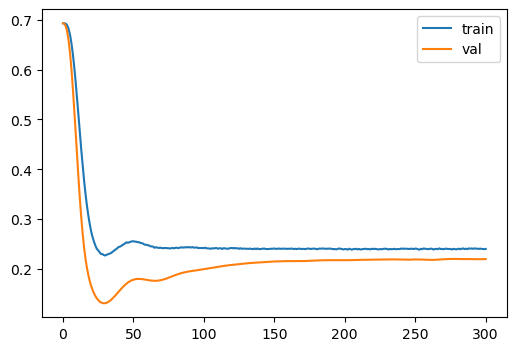

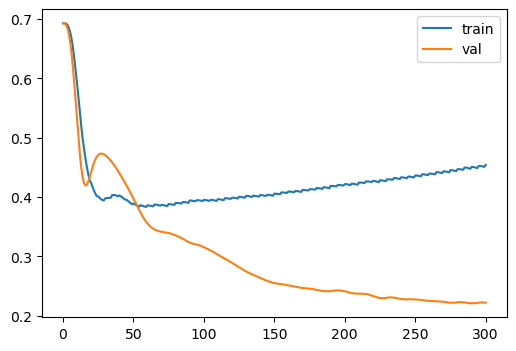

In [183]:
plot_train_val_loss(lgc_stats)
plot_train_val_loss(lgc_stats_hard)

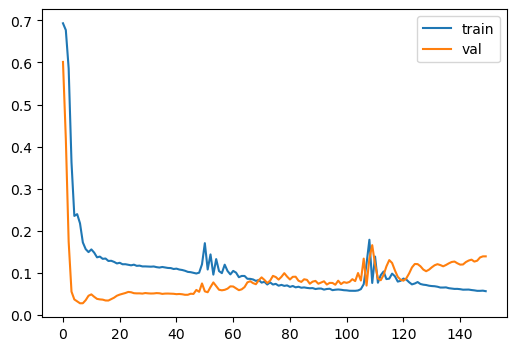

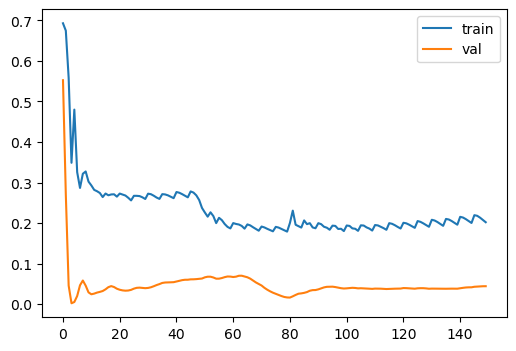

In [23]:
plot_train_val_loss(sage_stats)
plot_train_val_loss(sage_stats_hard)

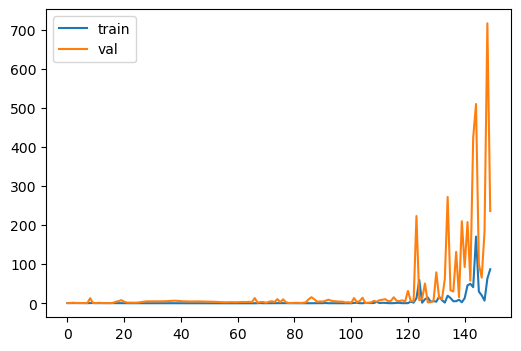

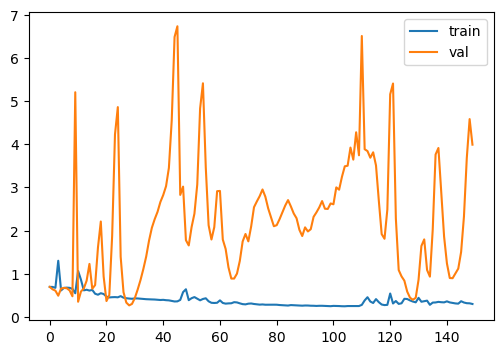

In [24]:
plot_train_val_loss(gat_stats)
plot_train_val_loss(gat_stats_hard)

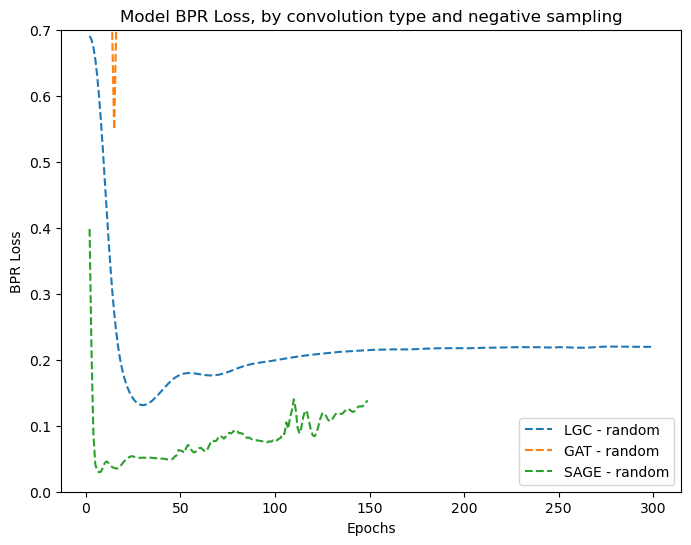

In [25]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats["val"][key])).rolling(3).mean()
gat_loss = pd.Series(detach_loss(gat_stats["val"][key])).rolling(3).mean()
sage_loss = pd.Series(detach_loss(sage_stats["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)
idx2 = np.arange(0, len(gat_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx2, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx2, sage_loss, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()

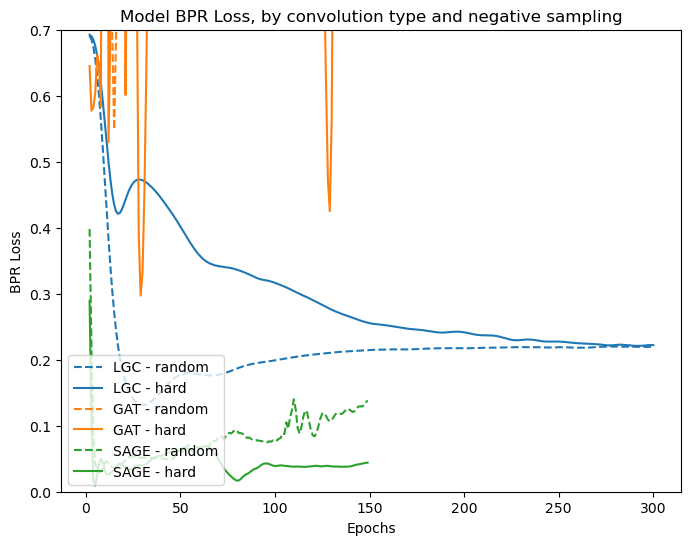

In [26]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "loss"
lgc_loss = pd.Series(detach_loss(lgc_stats["val"][key])).rolling(3).mean()
gat_loss = pd.Series(detach_loss(gat_stats["val"][key])).rolling(3).mean()
sage_loss = pd.Series(detach_loss(sage_stats["val"][key])).rolling(3).mean()
lgc_hard_loss = pd.Series(detach_loss(lgc_stats_hard["val"][key])).rolling(3).mean()
gat_hard_loss = pd.Series(detach_loss(gat_stats_hard["val"][key])).rolling(3).mean()
sage_hard_loss = pd.Series(detach_loss(sage_stats_hard["val"][key])).rolling(3).mean()
idx = np.arange(0, len(lgc_loss), 1)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_loss, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_loss, color = colors[0], label = "LGC - hard")
ax.plot(idx2, gat_loss, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx2, gat_hard_loss, color = colors[1], label = "GAT - hard")
ax.plot(idx2, sage_loss, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx2, sage_hard_loss, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower left')

ax.set_xlabel("Epochs")
ax.set_ylabel("BPR Loss")
ax.set_title("Model BPR Loss, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()

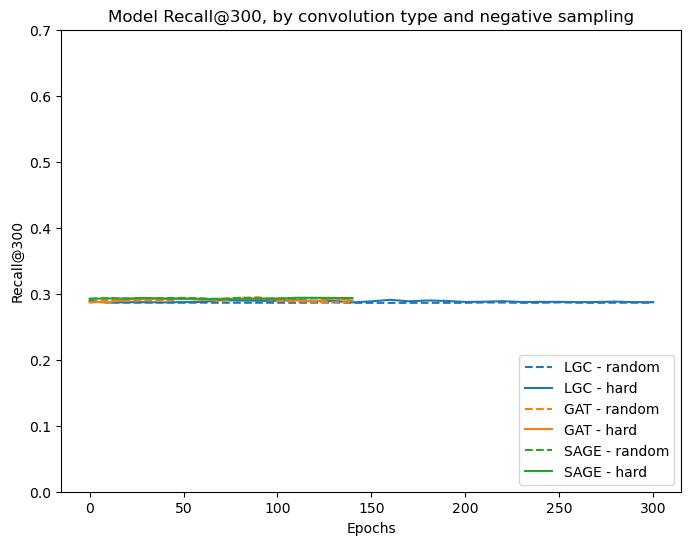

In [27]:
fig, ax = plt.subplots(1,1, figsize = (8, 6))
key = "recall"
lgc_recall = lgc_stats["val"][key]
gat_recall = gat_stats["val"][key]
sage_recall = sage_stats["val"][key]
lgc_hard_recall = lgc_stats_hard["val"][key]
gat_hard_recall = gat_stats_hard["val"][key]
sage_hard_recall = sage_stats_hard["val"][key]
# increment by 10
idx = np.arange(0, 10 * len(lgc_recall), 10)
idx2 = np.arange(0, 10 * len(gat_recall), 10)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
ax.plot(idx, lgc_recall, color = colors[0], linestyle = 'dashed', label = "LGC - random")
ax.plot(idx, lgc_hard_recall, color = colors[0], label = "LGC - hard")
ax.plot(idx2, gat_recall, color = colors[1], linestyle = 'dashed', label = "GAT - random")
ax.plot(idx2, gat_hard_recall, color = colors[1], label = "GAT - hard")
ax.plot(idx2, sage_recall, color = colors[2], linestyle = 'dashed', label = "SAGE - random")
ax.plot(idx2, sage_hard_recall, color = colors[2], label = "SAGE - hard")
ax.legend(loc = 'lower right')

ax.set_xlabel("Epochs")
ax.set_ylabel("Recall@300")
ax.set_title("Model Recall@300, by convolution type and negative sampling")
ax.set_ylim(0, 0.7)
plt.show()